# ПРОЕКТ 5 (PJ-03)

## Задачи пректа:
* EDA предоставленных данных
* Создание скоринговой модели
* Эксперименты с моделью
* Подбор гиперпараметров
* Получение предсказанных моделью значений для участие в соревновании на Kaggle

## Описание датасета

Исходный датасет состоит из 19 столбцов:

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заёмщика
* age - возраст заёмщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля-иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия «хорошей» работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заёмщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - наличие дефолта (целевая переменная)

In [1]:
# conda install -c conda-forge imbalanced-learn

## Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt
import seaborn as sns

import warnings

## Установки

In [3]:
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))


%matplotlib inline
warnings.filterwarnings("ignore")
path = '../Project_5_Scoring/'

# Kaggle
# DATA_DIR = '/kaggle/input/sf-scoring/'

pd.set_option('precision', 4)

## Загрузка данных

In [4]:
# Загрузка данных
df_train = pd.read_csv(f'{path}train.csv')
df_test = pd.read_csv(f'{path}test.csv')
sample_submission = pd.read_csv(f'{path}sample_submission.csv')

# Kaggle
# df_train = pd.read_csv(DATA_DIR +'/train.csv')
# df_test = pd.read_csv(DATA_DIR +'/test.csv')
# sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

## Предобработка

In [5]:
def fill_educ_nan(data):
    '''
    Функция пропорционального заполнения 
    пропусков в 'education'
    '''
    na = data.education.isna().sum()  # фиксируем количество пустых ячеек

    disp = data.education.value_counts()  # расписываем по категориям
    s = disp.sum()
    w = np.zeros(len(disp))  # формируем пустой массив весов

    for i in range(len(disp)):  # расчитваем веса категорий
        w[i] = disp[i]/s

    #  массив с количеством пропусков, пропорционально распределенных между категориями
    w_data = np.uint32(np.array([np.round(x, 0) for x in w * na]))

    #  исправляем ошибки округления
    if np.sum(w_data) < na:
        w_data[0] = w_data[0] + 1

    #  получаем список индексов пустых ячеек
    to_fill_index = data.loc[data.education.isna()].index

    #  заполняем пустые ячейки номерами соответствующих категорий
    n = 0
    cat = 0
    for w in w_data:
        for i in range(w):
            data.education.loc[to_fill_index[n]] = cat
            n += 1
        cat += 1

    print('было Nan:', na)
    print('было значений в категории:', np.asarray(disp) - np.asarray(w_data))
    print('стало значений в категории:', np.asarray(disp))
    print('разница:', np.asarray(w_data))
    print('стало не Nan:', np.sum(w_data))


def graph_plot(column, data=df_train):
    '''
    Построение гистограм c боксплотами
    '''
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    column.hist(bins=100)
    plt.title(col)
    plt.subplot(122)
    sns.boxplot(x='default', y=column, data=data)
    plt.show()


def count_plot(column, data=df_train):
    '''
    Построение гистограм
    '''
    ax = sns.countplot(x=column, data=data)
    plt.tight_layout()
    plt.xticks([])
    plt.show()


def count_plot_hue(column, data=df_train):
    '''
    Построение гистограм относительно 'default'
    '''
    ax = sns.countplot(x=data['default'], hue=column, data=data)
    plt.tight_layout()
    plt.show()


def df_describe(df):
    '''
    Вывод статистки
    '''
    desc = df.describe(include='all', percentiles=[
                       0.5]).T  # сохранение отчета от df.describe()
    # получение и сохранение дополнительных статистик/свойств
    desc['type'] = [type(x) for x in df.iloc[0]]  # тип данных
    desc['NaN'] = df.isna().sum()                # количество пропусков
    desc.unique = df.nunique()                   # количество уникальных значений
    # самое распрстроненноё значение
    desc.top = df.mode(axis=0).iloc[0]
    desc.freq = [df[col].value_counts().iloc[0]
                 for col in df.columns]  # количество top в признаке
    return desc


def outliers_iqr(ys):
    '''
    Вывод индексов значений за пределами +/-1.5IRQ
    '''
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)

    return np.where(~((ys > upper_bound) | (ys < lower_bound)))[0]


def lble_encod(df, col):
    '''
    Кодирование бинарных признаков
    '''
    label_encoder = LabelEncoder()

    for column in col:
        df[column] = label_encoder.fit_transform(df[column])


def cnt_metr(y_true, y_pred, y_pred_proba):
    '''
    Рассчет метрик
    '''
    metric = {}
    conf_matr = confusion_matrix(y_true, y_pred)
    metric['TN'] = conf_matr[0, 0]
    metric['FP'] = conf_matr[0, 1]
    metric['FN'] = conf_matr[1, 0]
    metric['TP'] = conf_matr[1, 1]
    metric['accuracy'] = accuracy_score(y_true, y_pred)
    metric['precision'] = precision_score(y_true, y_pred)
    metric['recall'] = recall_score(y_true, y_pred)   
    metric['f1'] = f1_score(y_true, y_pred)
    metric['roc_auc'] = roc_auc_score(y_true, y_pred_proba)

    return metric


def roc_auc_plt(y_true, y_pred_proba):
    '''
    Построение кривой ROC AUC
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()


def class_model(model, col_name):
    '''
    Расчет и вывод метрик для различных моделей.
    Построение ROC AUC
    '''
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_validation)
    y_pred_proba = model.predict_proba(X_validation)[:, 1]
    metric = cnt_metr(y_true, y_pred, y_pred_proba)
    # формирование столбца со значениями метрик
    df_metrics[col_name] = pd.Series(metric)
    display(df_metrics)
    roc_auc_plt(y_true, y_pred_proba)

## Знакомство с данными и первичная обработка

In [6]:
# Добавим в 'test' колонку 'default' и заполним ее 111
df_test['default'] = 111

# Добавляем метку train/test
df_train['sample'] = 'train'
df_test['sample'] = 'test'

# Объединяем датасеты
df = pd.concat([df_train, df_test], ignore_index=True)

# сохраняем индексы наблюдений из train
train_index = df[df['sample'] == 'train'].index
# сохраняем индексы наблюдений из test
test_index = df[df['sample'] == 'test'].index

Посмотрим общую статистику по всем признакам в объединенном датасете.

In [7]:
display(df_describe(df))

,count,unique,top,freq,mean,std,min,50%,max,type,NaN
client_id,110148.0,110148,1,1,55074.5,31797.1331,1.0,55074.5,110148.0,<class 'numpy.int64'>,0
app_date,110148,120,18MAR2014,1491,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
education,109670,5,SCH,57998,NaN,NaN,NaN,NaN,NaN,<class 'str'>,478
sex,110148,2,F,61836,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
age,110148.0,52,31.0,4084,39.2494,11.5181,21.0,37.0,72.0,<class 'numpy.int64'>,0
car,110148,2,N,74290,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
car_type,110148,2,N,89140,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
decline_app_cnt,110148.0,24,0.0,91471,0.2732,0.7991,0.0,0.0,33.0,<class 'numpy.int64'>,0
good_work,110148.0,2,0.0,91917,0.1655,0.3716,0.0,0.0,1.0,<class 'numpy.int64'>,0
score_bki,110148.0,102618,-1.7753,517,-1.9045,0.4994,-3.6246,-1.9208,0.1998,<class 'numpy.float64'>,0


Пропуски присутствуют только в одном признаке - 'education'.

Разброс в числовых признаках не очень велик. Только 'income' варьирует в широких приделах. В дальнейшем применим логарифмирование или стандартизацию.

В признаке 'decline_app_cnt' можно будет посмотреть структуру и, возможно, сократить число уникальных значений с тем, чтобы перевести его в категориальный тип.

In [8]:
df_train.shape

(73799, 20)

In [9]:
df_test.shape

(36349, 20)

Посчитаем соотношение недефолтных клиентов к дефолтным. Это будет ориентиром для оценки в первом приближении работу модели. Соотношение в тестовой выборке должно быть примерно тем же.

In [10]:
vc = df.default.loc[(df.default != 111)].value_counts()

In [11]:
ratio = vc[0] / vc[1]
ratio

6.874413145539906

Количество недефолтных клиентов примерно в 7 раз превышает количество дефолтных.

В дальнейшем будем анализировать признаки train и дублировать обработку в test. С этими датасетами так будет эффективнее.

### Заполнение пропусков

Заполним пропуски в колонке 'education'.

In [12]:
df_train.education.value_counts()

SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

In [13]:
df_test.education.value_counts()

SCH    19138
GRD    11403
UGR     4932
PGR      608
ACD       97
Name: education, dtype: int64

Для удобства, обозначим категории числовыми метками.

In [14]:
education = {'SCH': 1, 'GRD': 2, 'UGR': 3, 'PGR': 4, 'ACD': 5}
educ_dct = {val: k for k, val in enumerate(education)}
df_train.education = df_train.education.map(educ_dct)
df_test.education = df_test.education.map(educ_dct)

In [15]:
df_train.education.value_counts().sort_index()

0.0    38860
1.0    23365
2.0     9816
3.0     1257
4.0      194
Name: education, dtype: int64

In [16]:
df_test.education.value_counts().sort_index()

0.0    19138
1.0    11403
2.0     4932
3.0      608
4.0       97
Name: education, dtype: int64

Заполним пропуски следующим образом. Чтобы не нарушать структуру данных в признаке, распреденим пропуски пропорционально количеству значений в категории. 

Для этого найдем доли каждой категории в общем количестве, возьмем общее количество пропусков и умножим на вес каждой категории. 

В результате мы получим количество дополнительных не NaN значений пропорционально для каждой категории.

In [17]:
fill_educ_nan(df_train)

было Nan: 307
было значений в категории: [38698 23267  9775  1252   193]
стало значений в категории: [38860 23365  9816  1257   194]
разница: [162  98  41   5   1]
стало не Nan: 307


In [18]:
fill_educ_nan(df_test)

было Nan: 171
было значений в категории: [19047 11349  4909   605    97]
стало значений в категории: [19138 11403  4932   608    97]
разница: [91 54 23  3  0]
стало не Nan: 171


### Распределение признаков по типам

Распределим признаки по трем типам: числовые, бинарные, категорийные. Признак 'client_id' удалим, как не несущий полезной для моделирования нагрузки.

In [19]:
# Задаем числовые признаки:
num_cols = df.columns[df.nunique() >= 25].drop(
    ['app_date', 'client_id']).to_list()
# Задаем категориальные бинарные признаки:
bin_cols = df.columns[df.nunique() == 2].drop(['sample']).to_list()
# Задаем категориальные небинарные признаки:
cat_cols = df.columns[(df.nunique() > 2) & (
    df.nunique() < 25)].drop(['default']).to_list()
# добавим эту колонку к категорийным, т.к. в дальнейшем ее соотв.образом преобразуем


# приводим временной ряд к числовому виду
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')
# заменяем дату на разницу между самой ранней датой и текущей
df.app_date = (df.app_date - df.app_date.min()).dt.days

df_train.app_date = pd.to_datetime(df_train.app_date, format='%d%b%Y')
df_train.app_date = (df_train.app_date - df_train.app_date.min()).dt.days

df_test.app_date = pd.to_datetime(df_test.app_date, format='%d%b%Y')
df_test.app_date = (df_test.app_date - df_test.app_date.min()).dt.days

# добавим признак 'app_date' к числовым
num_cols.append('app_date')

Проверяем:

In [20]:
print('num_cols:', num_cols)
print('bin_cols:', bin_cols)
print('cat_cols:', cat_cols)
# проверка состава списков колонок
len(set(num_cols + bin_cols + cat_cols)) == len(list(df.columns))-3

num_cols: ['age', 'score_bki', 'bki_request_cnt', 'income', 'app_date']
bin_cols: ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols: ['education', 'decline_app_cnt', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']


True

In [21]:
df.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
79964,48450,55,GRD,M,38,N,N,0,0,-2.6796,0,40,2,3,45000,1,3,N,111,test
45230,64844,71,UGR,F,29,N,N,0,0,-1.1898,1,40,1,3,25000,4,2,N,0,train
75949,34592,41,UGR,F,21,Y,N,0,0,-1.9008,0,60,2,3,25000,1,2,N,111,test
68558,106669,114,GRD,M,28,N,N,0,0,-2.2231,0,80,2,3,50000,1,2,N,0,train
42603,76748,82,GRD,F,57,N,N,0,0,-1.9953,0,40,1,2,31000,2,3,N,0,train


### Сбалансированность

Данные в целевой переменной не сбалансированы:

<AxesSubplot:xlabel='default', ylabel='count'>

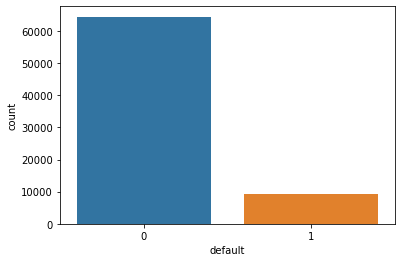

In [22]:
sns.countplot(x='default', data=df_train)

Оставим пока, как есть, для упрощенной модели.

## Числовые признаки

Посмотрим на распределение числвых признаков в исходном виде и после логарифмирования.

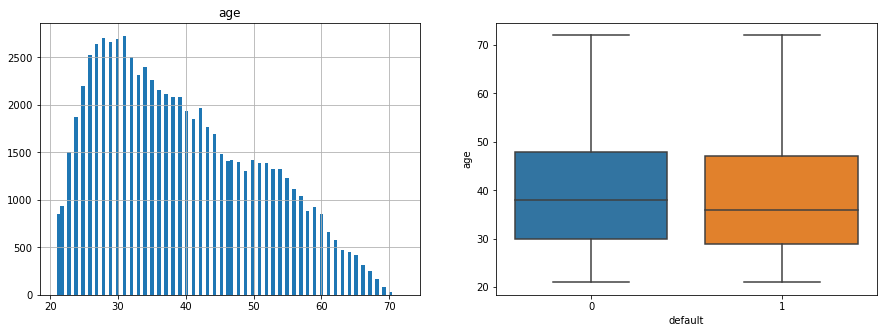

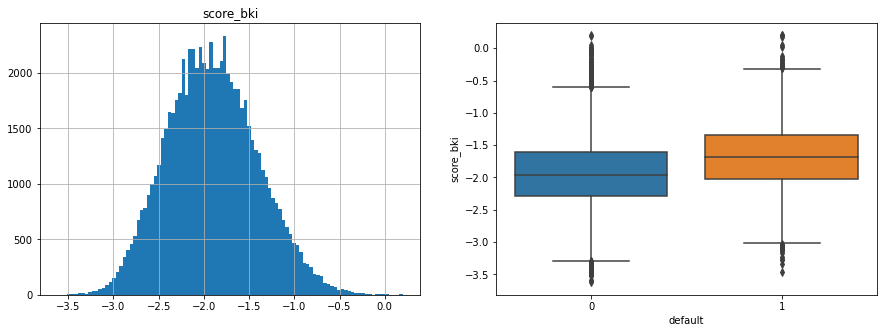

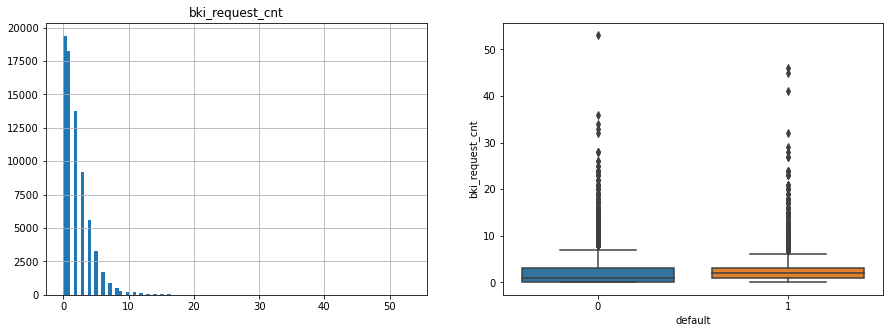

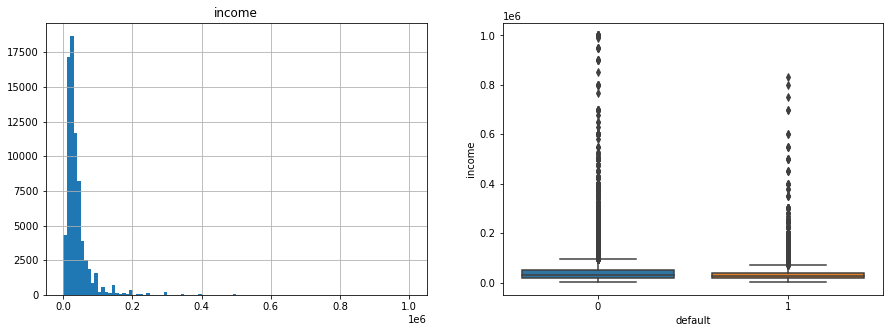

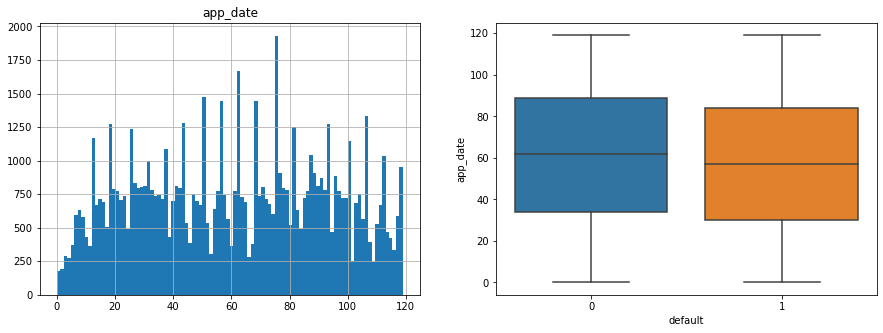

In [23]:
for col in num_cols:
    graph_plot(df_train[col])

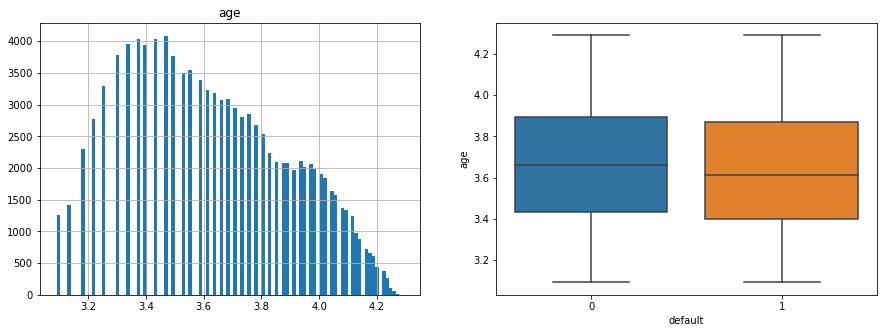

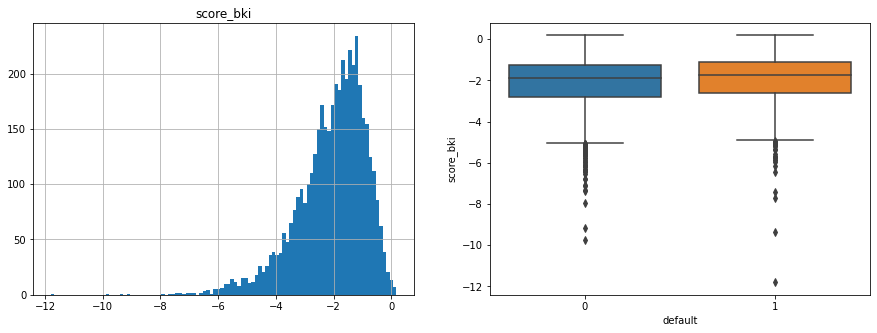

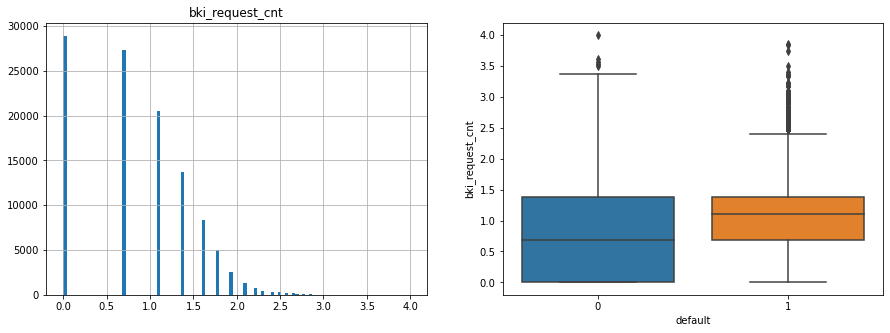

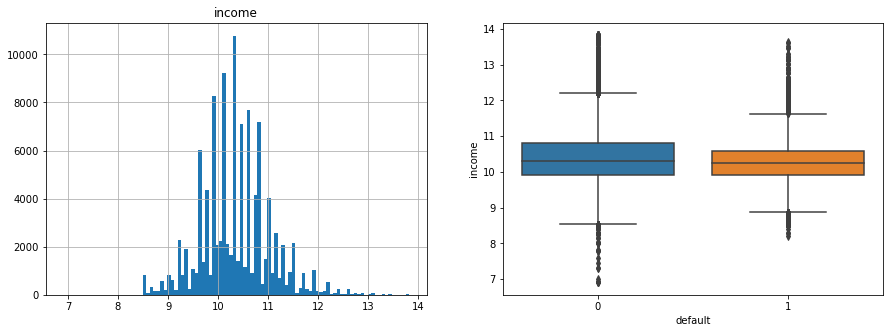

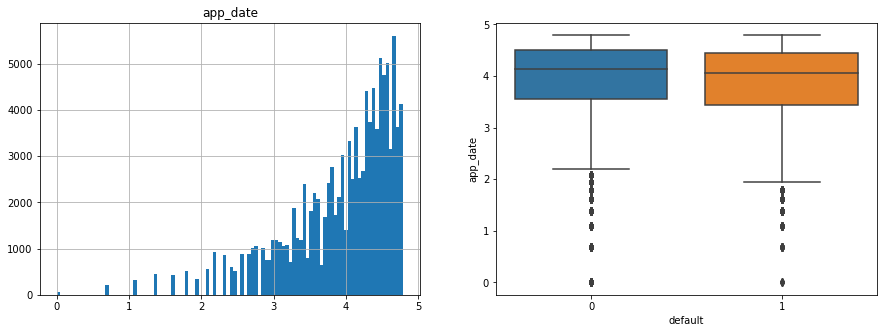

In [24]:
for col in num_cols:
    graph_plot(np.log(df[col]+1))

Целесообразно логарифмировать признак 'income'. Эксперименты показали, что с логарифмированным признаком 'income' все показателей моделей значительно лучше, чем без логорифмированного. Даже после стандартизации.

In [25]:
df_train['income'] = df_train.income.apply(lambda x: np.log(x) if x > 0 else x)
df_test['income'] = df_test.income.apply(lambda x: np.log(x) if x > 0 else x)

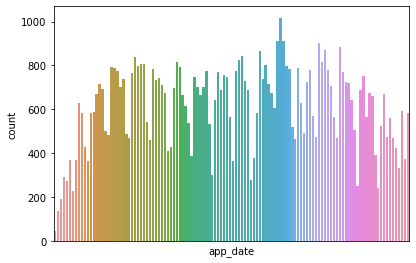

In [26]:
count_plot('app_date')

Признак 'app_date' явно отражает недельные циклы. Логарифмирование принципиальных изменений не привносит.

### Очистка от выбросов

Посмотрим, как изменится картина после избавления от выбросов.

In [27]:
df_train_irq = df_train.copy()
# Избавимся от выбросов
for col in num_cols:
    o = outliers_iqr(df_train_irq[col])
    df_train_irq = df_train_irq.iloc[o]

Длина векторов признаков изменилась:

In [28]:
df_train_irq.shape

(69827, 20)

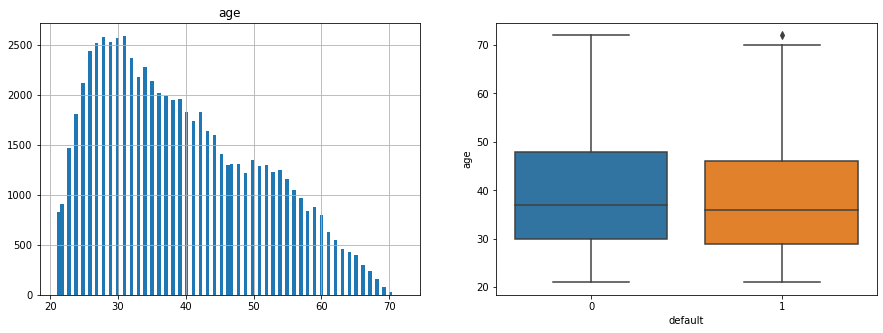

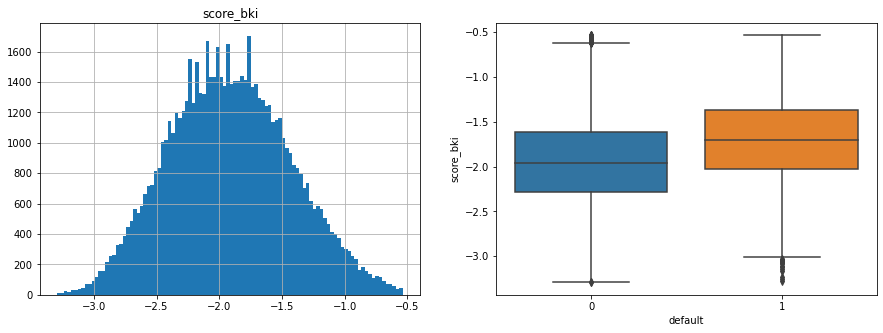

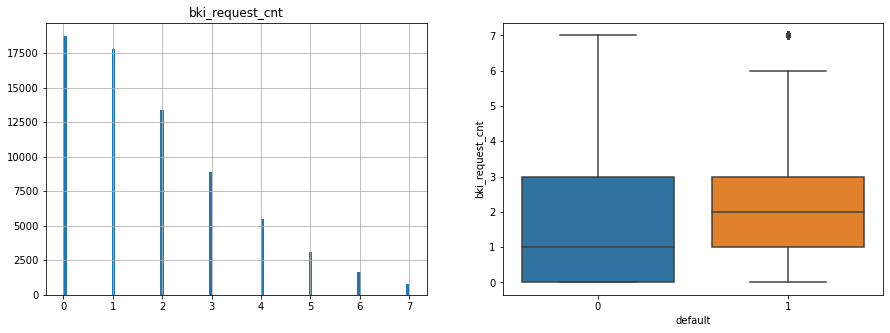

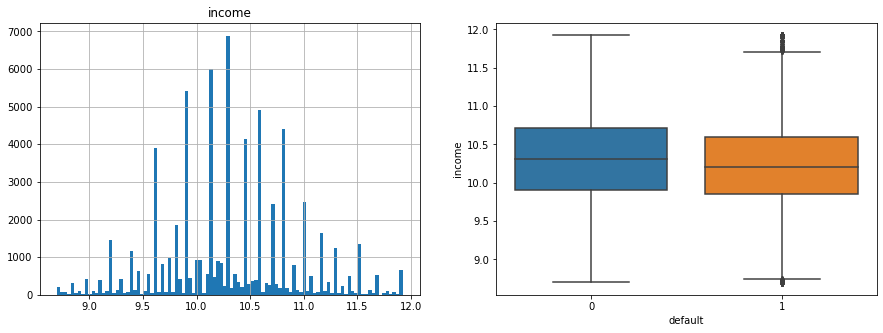

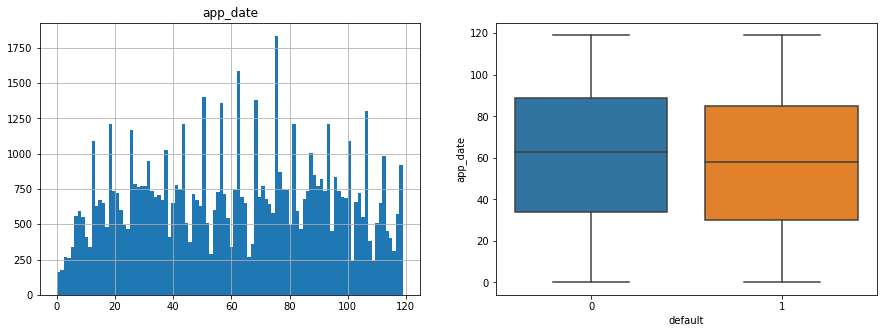

In [29]:
for col in num_cols:
    graph_plot(df_train_irq[col])

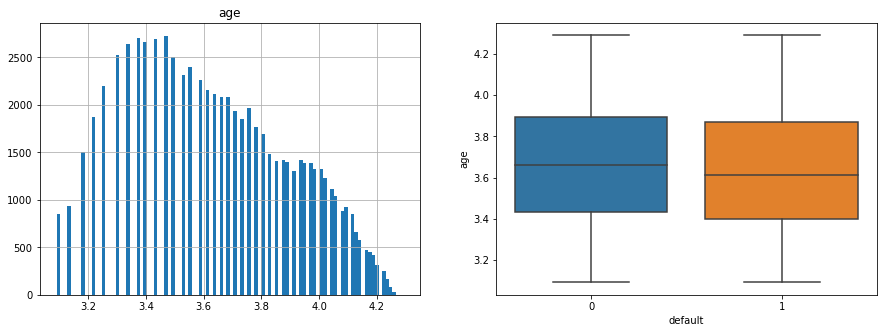

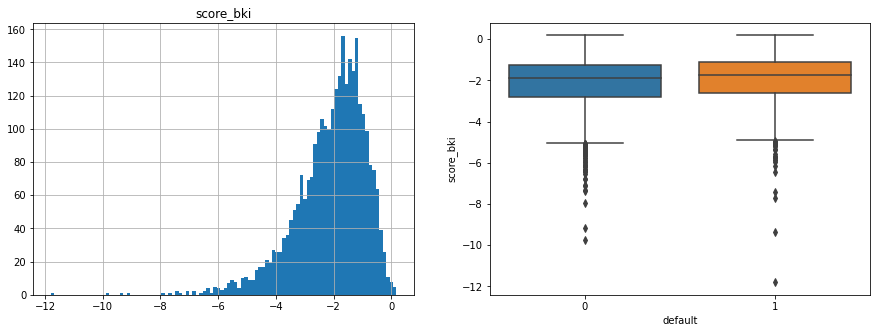

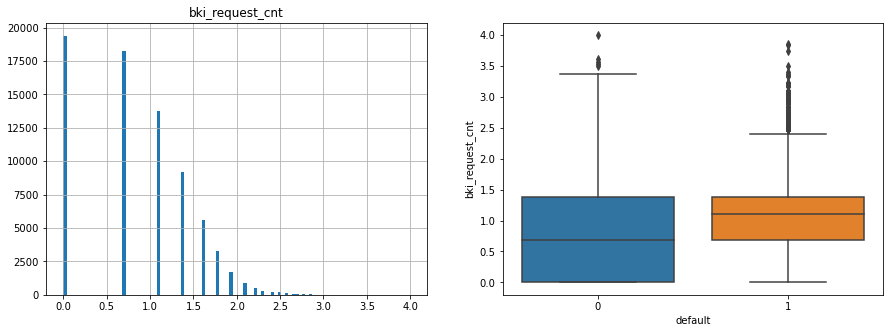

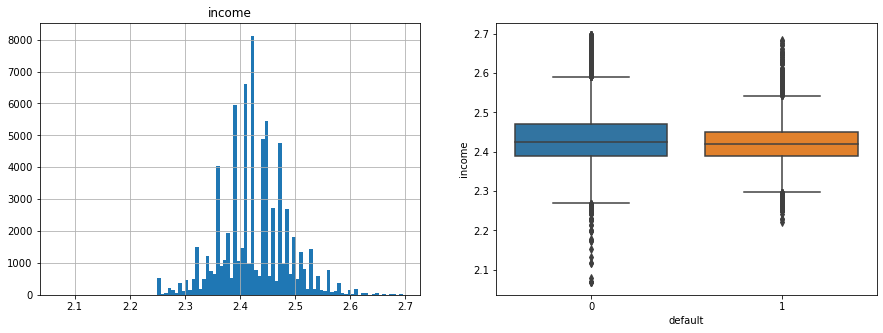

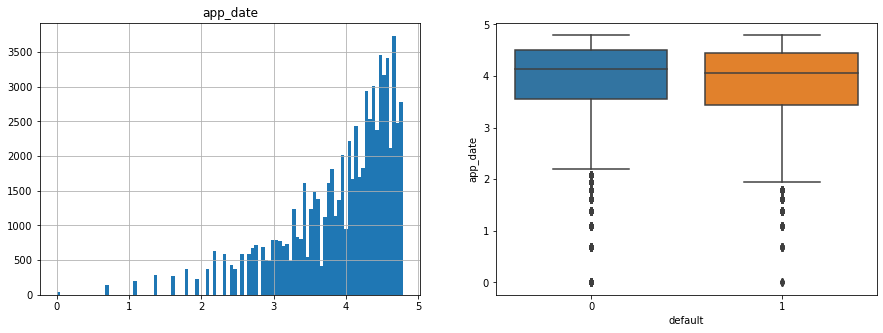

In [30]:
for col in num_cols:
    graph_plot(np.log(df_train[col]+1))

Данные стали "почище". Можно будет применить их в построении моделей и посмотерть метрики.

### Корреляция числовых признаков

<AxesSubplot:>

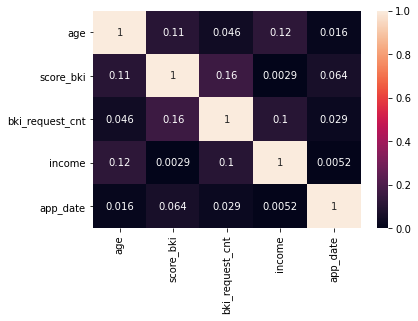

In [31]:
sns.heatmap(df_train[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Ярко выраженной корреляции между признаками нет. Проблем, связанных с мультиколлинеарностью, не будет.

### Значимость числовых признаков

<AxesSubplot:>

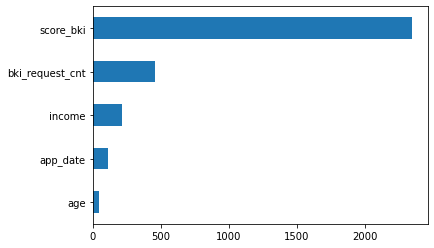

In [32]:
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[
                    0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Самым значимым является признак 'score_bki'. Остальные минимум в 4-5 раз менее значимы. 

Однако сокращать количество признаков в данной задаче не будем, т.к. их и так мало.

### Feature engineering

В рамках данного датасета создание новых признаков на основе имеющихся приводит к проблеме мультиколлиниарности. Можно было бы использовать какие-нибудь сторонние дополнительные данные. Однако, ограниченное время на выполнение работы не позволяет провести качественный подбор и анализ новых признаков.

Остановимся на введении признака "текущая дата минус самая ранняя дата в днях".

   ## Категорийные признаки

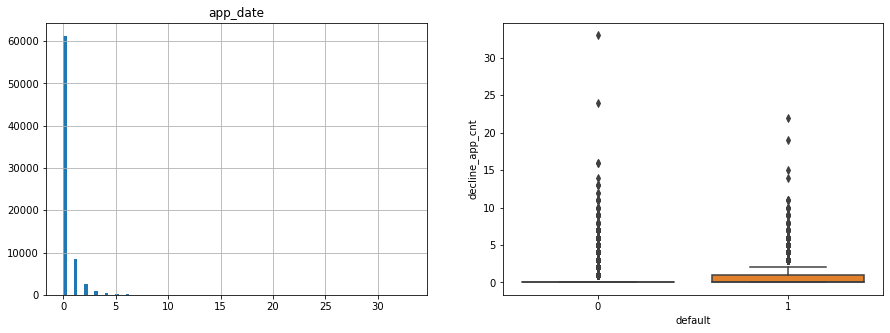

In [33]:
graph_plot(df_train['decline_app_cnt'])

Основное количество признака 'decline_app_cnt' сосредоточено около 0.

In [34]:
df_train.decline_app_cnt.value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
15        1
19        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

Сократим количество категорий до четырех. 

In [35]:
df_train.decline_app_cnt = df_train.decline_app_cnt.apply(
    lambda x: x if x < 3 else 3)
df_test.decline_app_cnt = df_test.decline_app_cnt.apply(
    lambda x: x if x < 3 else 3)

In [36]:
df_train.decline_app_cnt.value_counts()

0    61214
1     8397
2     2468
3     1720
Name: decline_app_cnt, dtype: int64

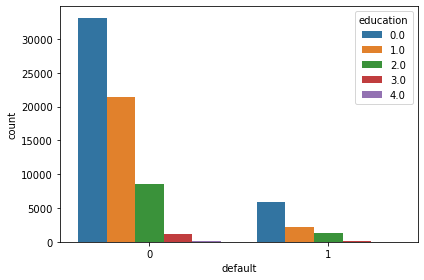

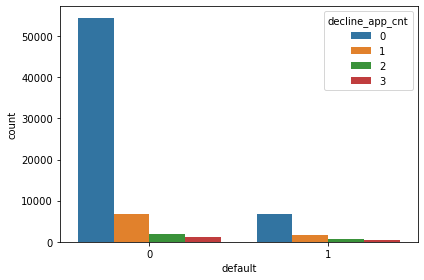

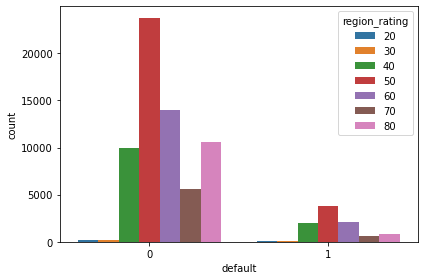

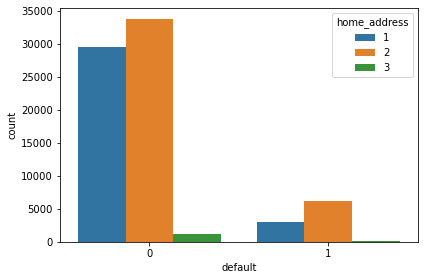

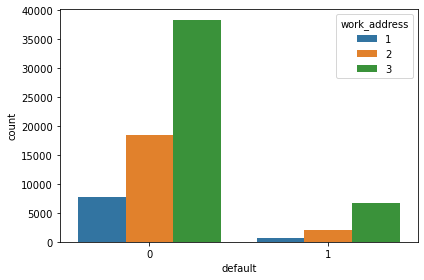

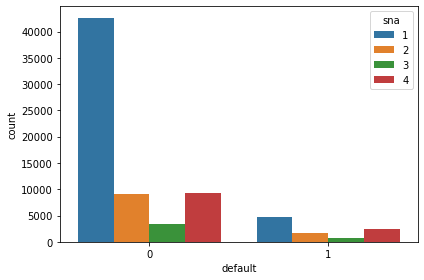

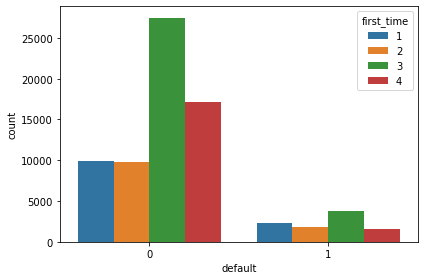

In [37]:
for col in cat_cols:
    count_plot_hue(df_train[col], data=df_train)

Приведем все значения в категорийных признаков к единообразным числовым маркерам.

In [38]:
lble_encod(df_train, cat_cols)
lble_encod(df_test, cat_cols)

In [39]:
# убедимся в преобразовании    
df_train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
65781,105730,113,2,F,33,N,N,0,1,-2.1221,4,4,0,0,9.6803,2,1,N,0,train
19224,95830,101,2,M,30,N,N,0,0,-1.5139,1,2,0,1,10.4341,0,1,N,0,train
28589,40995,47,0,M,57,N,N,0,0,-2.9524,4,5,0,0,10.5966,0,3,N,0,train
55477,34985,41,0,F,34,N,N,0,0,-0.9837,3,5,0,1,10.8198,0,2,N,0,train
64905,54363,61,1,F,32,N,N,0,0,-2.2182,2,4,1,2,10.3090,2,0,N,0,train


In [40]:
df_test.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
30946,54447,61,1,M,27,Y,Y,0,1,-2.1610,1,5,2,2,10.7144,0,3,N,111,test
14517,109759,119,0,F,59,N,N,0,0,-2.2301,0,3,1,2,9.3057,3,2,N,111,test
15259,20748,27,1,M,36,N,N,0,1,-2.9810,0,6,1,2,11.5129,0,1,Y,111,test
18649,6808,13,0,M,45,N,N,0,0,-1.6386,0,6,1,2,11.0021,0,2,Y,111,test
14126,43397,49,0,F,59,N,N,1,0,-1.0105,2,2,0,1,8.8537,0,2,N,111,test


### Значимость категорийных признаков

<AxesSubplot:>

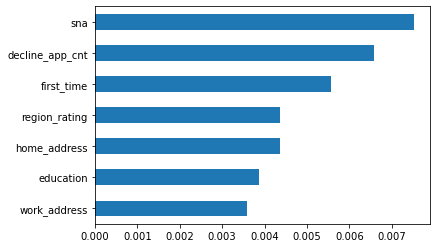

In [41]:
imp_cat = pd.Series(mutual_info_classif(df_train[cat_cols], df_train['default'],
                                        discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Все признаки близки друг к другу по значимости.

Преобразуем категорийные признаки в дамми переменные:

In [42]:
df_train = pd.get_dummies(df_train, columns=cat_cols)
df_test = pd.get_dummies(df_test, columns=cat_cols)

In [43]:
df_train.head()

,client_id,app_date,sex,age,car,car_type,good_work,score_bki,bki_request_cnt,income,...,work_address_1,work_address_2,sna_0,sna_1,sna_2,sna_3,first_time_0,first_time_1,first_time_2,first_time_3
0,25905,31,M,62,Y,Y,0,-2.0088,1,9.7981,...,1,0,0,0,0,1,1,0,0,0
1,63161,70,F,59,N,N,0,-1.5323,3,9.8522,...,0,1,0,0,0,1,1,0,0,0
2,25887,31,M,25,Y,N,0,-1.4081,1,10.3090,...,1,0,1,0,0,0,0,0,0,1
3,16222,22,F,53,N,N,0,-2.0575,2,9.2103,...,0,1,1,0,0,0,0,0,1,0
4,101655,107,M,48,N,N,1,-1.2447,1,10.3090,...,0,1,1,0,0,0,0,0,0,1


In [44]:
df_test.head()

,client_id,app_date,sex,age,car,car_type,good_work,score_bki,bki_request_cnt,income,...,work_address_1,work_address_2,sna_0,sna_1,sna_2,sna_3,first_time_0,first_time_1,first_time_2,first_time_3
0,74835,80,M,29,Y,Y,0,-2.2719,3,10.8198,...,1,0,1,0,0,0,0,0,0,1
1,17527,23,F,39,N,N,0,-1.5050,2,8.5172,...,1,0,0,0,0,1,0,0,1,0
2,75683,81,M,50,Y,Y,0,-1.6913,1,10.3090,...,1,0,1,0,0,0,0,0,1,0
3,26883,33,M,56,N,N,0,-2.3742,1,9.7410,...,1,0,1,0,0,0,0,0,1,0
4,28862,34,F,38,N,N,0,-2.4875,0,11.6952,...,0,1,1,0,0,0,0,0,1,0


In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          73799 non-null  int64  
 1   app_date           73799 non-null  int64  
 2   sex                73799 non-null  object 
 3   age                73799 non-null  int64  
 4   car                73799 non-null  object 
 5   car_type           73799 non-null  object 
 6   good_work          73799 non-null  int64  
 7   score_bki          73799 non-null  float64
 8   bki_request_cnt    73799 non-null  int64  
 9   income             73799 non-null  float64
 10  foreign_passport   73799 non-null  object 
 11  default            73799 non-null  int64  
 12  sample             73799 non-null  object 
 13  education_0        73799 non-null  uint8  
 14  education_1        73799 non-null  uint8  
 15  education_2        73799 non-null  uint8  
 16  education_3        737

In [46]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          36349 non-null  int64  
 1   app_date           36349 non-null  int64  
 2   sex                36349 non-null  object 
 3   age                36349 non-null  int64  
 4   car                36349 non-null  object 
 5   car_type           36349 non-null  object 
 6   good_work          36349 non-null  int64  
 7   score_bki          36349 non-null  float64
 8   bki_request_cnt    36349 non-null  int64  
 9   income             36349 non-null  float64
 10  foreign_passport   36349 non-null  object 
 11  default            36349 non-null  int64  
 12  sample             36349 non-null  object 
 13  education_0        36349 non-null  uint8  
 14  education_1        36349 non-null  uint8  
 15  education_2        36349 non-null  uint8  
 16  education_3        363

## Бинарные признаки

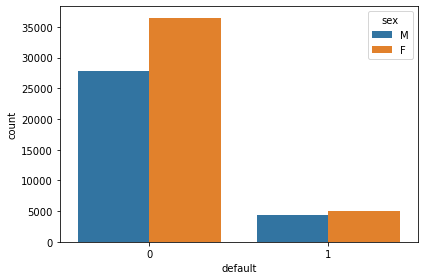

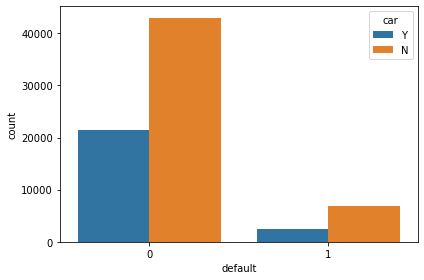

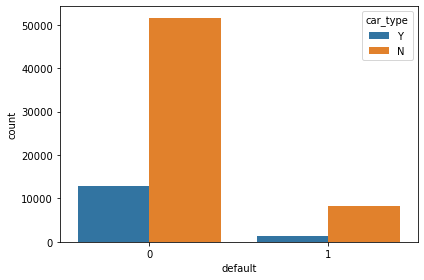

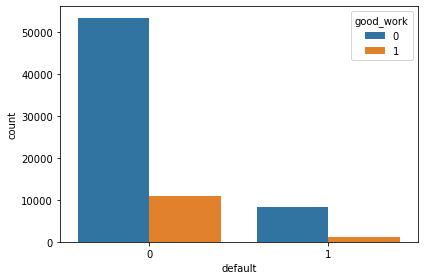

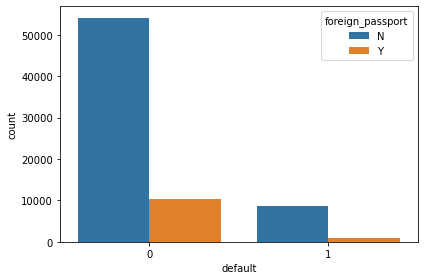

In [47]:
for col in bin_cols:
    count_plot_hue(df_train[col], data=df_train)

Преобразуем значения бинарных признаков в числа:

In [48]:
lble_encod(df_train, bin_cols)
lble_encod(df_test, bin_cols)

In [49]:
# убедимся в преобразовании    
df_train[bin_cols].sample(5)

,sex,car,car_type,good_work,foreign_passport
15365,1,0,0,0,0
1737,0,0,0,0,0
57315,1,0,0,0,0
23907,0,0,0,0,1
59081,0,0,0,0,0


In [50]:
df_test[bin_cols].sample(5)

,sex,car,car_type,good_work,foreign_passport
34376,0,0,0,1,0
5535,0,0,0,0,0
23503,0,0,0,0,0
33353,0,0,0,1,0
24823,0,0,0,0,0


### Значимость бинарных признаков

<AxesSubplot:>

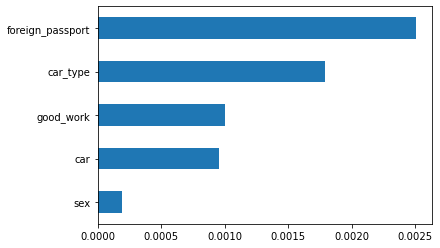

In [51]:
imp_cat = pd.Series(mutual_info_classif(df_train[bin_cols], df_train['default'],
                                        discrete_features=True), index=bin_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Самыми значимыми бинарными признаками являются наличие загранпаспорта и начилие иностранного автомобиля. 

Сокращать какие-либо признаки не будем.

## Обучение

Основная идея данного раздела - поэкспериментировать с составом признаков и проверить на них несколько классификаторов. Оценку будем проводить по метрикам: confusiom matrix, f1-score, accuracy, ROC AUC.

Для начала, разбиваем df_train на train и validation.

In [52]:
train, validation = train_test_split(df_train, test_size=0.2, random_state=42)
X_train = train.drop(['client_id', 'default', 'sample'], axis=1).values
Y_train = train['default'].values
X_validation = validation.drop(
    ['client_id', 'default', 'sample'], axis=1).values
y_true = validation['default'].values

In [53]:
train.shape

(59039, 43)

### Обучение без преобразований

На данных без системных преобразований (были только заполнены пропуски и логарифмирован один признак) проверим классификацию логистической регрессией, деревом решений и случайным лесом.

#### LogisticRegression

,LR
TN,12873.0000
FP,60.0000
FN,1785.0000
TP,42.0000
accuracy,0.8750
precision,0.4118
recall,0.0230
f1,0.0435
roc_auc,0.7432


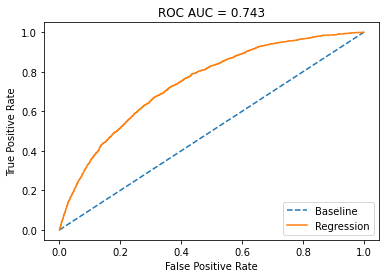

In [54]:
model_LR = LogisticRegression(max_iter=1000)
model_LR.fit(X_train, Y_train)
y_pred = model_LR.predict(X_validation)
y_pred_proba = model_LR.predict_proba(X_validation)[:, 1]
metric = cnt_metr(y_true, y_pred, y_pred_proba)
df_metrics = pd.DataFrame.from_dict(metric, orient='index', columns=['LR'])
display(df_metrics)
roc_auc_plt(y_true, y_pred_proba)

#### DecisionTreeClassifier

,LR,DTC
TN,12873.0000,11212.0000
FP,60.0000,1721.0000
FN,1785.0000,1391.0000
TP,42.0000,436.0000
accuracy,0.8750,0.7892
precision,0.4118,0.2021
recall,0.0230,0.2386
f1,0.0435,0.2189
roc_auc,0.7432,0.5528


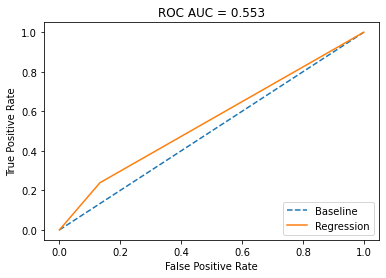

In [55]:
model_DTC = DecisionTreeClassifier(random_state=23)
class_model(model_DTC, 'DTC')

#### RandomForestClassifier

,LR,DTC,RFC
TN,12873.0000,11212.0000,12880.0000
FP,60.0000,1721.0000,53.0000
FN,1785.0000,1391.0000,1785.0000
TP,42.0000,436.0000,42.0000
accuracy,0.8750,0.7892,0.8755
precision,0.4118,0.2021,0.4421
recall,0.0230,0.2386,0.0230
f1,0.0435,0.2189,0.0437
roc_auc,0.7432,0.5528,0.7137


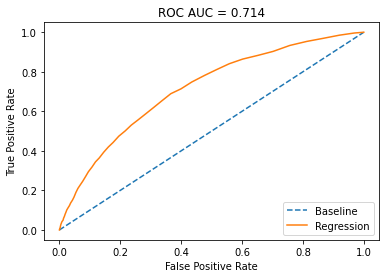

In [56]:
model_RFC = RandomForestClassifier()
class_model(model_RFC, 'RFC')

Все три модели показали неспособность определять дефолтных клиентов.

Скорее всего, данная ошибка возникает из-за несбалансированности целевой переменной: количество недефолтных клиентов в 7 раз превышает количество дефолтных. Классификаторы не видят миноритарный класс.

Результаты, к которым мы стремимся, таковы:

In [57]:
validation.default.value_counts()

0    12933
1     1827
Name: default, dtype: int64

### Oversampling

Для устранения несбалансированности обогатим данные увеличив частоту дефолтных клиентов с помощью алгоритма SMOTE (синтетическая техника дублирования примеров миноритарного класса).
Данный алгоритм создаёт синтетические образцы на основе выборок минорного класса вместо создания их копий.

In [58]:
train, validation = train_test_split(df_train, test_size=0.2, random_state=42)
X_train = train.drop(['client_id', 'default', 'sample'], axis=1)
Y_train = train['default']
X_validation = validation.drop(['client_id', 'default', 'sample'], axis=1)
y_true = validation['default']

In [59]:
os = SMOTE(random_state=0)
columns = X_train.columns
os_data_X, os_data_y = os.fit_resample(X_train, Y_train)
X_train = pd.DataFrame(data=os_data_X, columns=columns)
Y_train = pd.DataFrame(data=os_data_y, columns=['default'])

print("Длина выборки: ", len(X_train))
print("Количество не дефолтов: ", len(Y_train[Y_train['default'] == 0]))
print("Количество дефолтов: ", len(Y_train[Y_train['default'] == 1]))
print("Доля не дефолтов в выбоке: ", len(
    Y_train[Y_train['default'] == 0])/len(X_train))
print("Доля дефолтов в выборке: ", len(
    Y_train[Y_train['default'] == 1])/len(X_train))

Длина выборки:  102988
Количество не дефолтов:  51494
Количество дефолтов:  51494
Доля не дефолтов в выбоке:  0.5
Доля дефолтов в выборке:  0.5


Проверим на этих полностью сбалансированных данных наши классификаторы.

#### LogisticRegression

,LR,DTC,RFC,OS_LR
TN,12873.0000,11212.0000,12880.0000,12851.0000
FP,60.0000,1721.0000,53.0000,82.0000
FN,1785.0000,1391.0000,1785.0000,1763.0000
TP,42.0000,436.0000,42.0000,64.0000
accuracy,0.8750,0.7892,0.8755,0.8750
precision,0.4118,0.2021,0.4421,0.4384
recall,0.0230,0.2386,0.0230,0.0350
f1,0.0435,0.2189,0.0437,0.0649
roc_auc,0.7432,0.5528,0.7137,0.7380


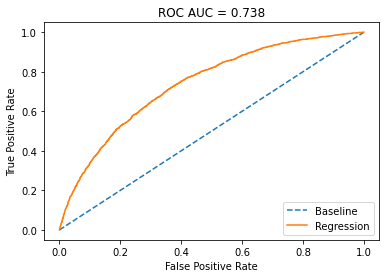

In [60]:
model_OS_LR = LogisticRegression(max_iter=1000)
class_model(model_OS_LR, 'OS_LR')

#### DecisionTreeClassifier

,LR,DTC,RFC,OS_LR,OS_DTC
TN,12873.0000,11212.0000,12880.0000,12851.0000,11042.0000
FP,60.0000,1721.0000,53.0000,82.0000,1891.0000
FN,1785.0000,1391.0000,1785.0000,1763.0000,1382.0000
TP,42.0000,436.0000,42.0000,64.0000,445.0000
accuracy,0.8750,0.7892,0.8755,0.8750,0.7783
precision,0.4118,0.2021,0.4421,0.4384,0.1905
recall,0.0230,0.2386,0.0230,0.0350,0.2436
f1,0.0435,0.2189,0.0437,0.0649,0.2138
roc_auc,0.7432,0.5528,0.7137,0.7380,0.5487


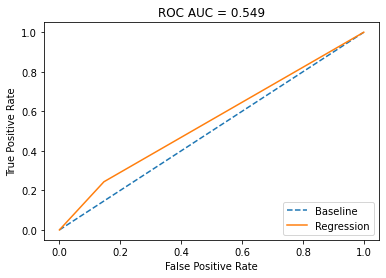

In [61]:
model_OS_DTC = DecisionTreeClassifier(random_state=23)
class_model(model_OS_DTC, 'OS_DTC')

#### RandomForestClassifier

,LR,DTC,RFC,OS_LR,OS_DTC,OS_RFC
TN,12873.0000,11212.0000,12880.0000,12851.0000,11042.0000,12714.0000
FP,60.0000,1721.0000,53.0000,82.0000,1891.0000,219.0000
FN,1785.0000,1391.0000,1785.0000,1763.0000,1382.0000,1698.0000
TP,42.0000,436.0000,42.0000,64.0000,445.0000,129.0000
accuracy,0.8750,0.7892,0.8755,0.8750,0.7783,0.8701
precision,0.4118,0.2021,0.4421,0.4384,0.1905,0.3707
recall,0.0230,0.2386,0.0230,0.0350,0.2436,0.0706
f1,0.0435,0.2189,0.0437,0.0649,0.2138,0.1186
roc_auc,0.7432,0.5528,0.7137,0.7380,0.5487,0.7048


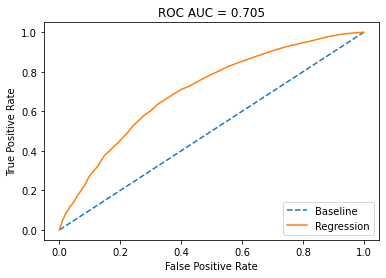

In [62]:
model_OS_RFC = RandomForestClassifier()
class_model(model_OS_RFC, 'OS_RFC')

Во всех случаях картина не изменилась: модели не видят миноритарный класс.

### Undersampling

#### Undersampling методом «Tomek Links»

Попробуем сбалансировать данные методом «Tomek Links». «Links» в данном случае — пары элементов из разных классов, находящиеся поблизости.


Используя алгоритм мы в конечном итоге удалим элемент пары из большего набора, что позволит классификатору отработать лучше.

In [63]:
train.shape

(59039, 43)

In [64]:
train[train.default == 0].shape

(51494, 43)

In [65]:
train, validation = train_test_split(df_train, test_size=0.2, random_state=42)
X_train = train.drop(['client_id', 'default', 'sample'], axis=1)
Y_train = train['default']
X_validation = validation.drop(['client_id', 'default', 'sample'], axis=1)
y_true = validation['default']

In [66]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='auto')
X_tl, y_tl = tl.fit_resample(X_train, Y_train)

X_train = pd.DataFrame(data=X_tl, columns=columns)
Y_train = pd.DataFrame(data=y_tl, columns=['default'])

print("Длина выборки: ", len(X_train))
print("Количество не дефолтов: ", len(Y_train[Y_train['default'] == 0]))
print("Количество дефолтов: ", len(Y_train[Y_train['default'] == 1]))
print("Доля не дефолтов в выбоке: ", len(
    Y_train[Y_train['default'] == 0])/len(X_train))
print("Доля дефолтов в выборке: ", len(
    Y_train[Y_train['default'] == 1])/len(X_train))

Длина выборки:  56511
Количество не дефолтов:  48966
Количество дефолтов:  7545
Доля не дефолтов в выбоке:  0.8664861708339969
Доля дефолтов в выборке:  0.13351382916600307


Колчиество не дефолтов немного сократилось.

,LR,DTC,RFC,OS_LR,OS_DTC,OS_RFC,US_TL_LR
TN,12873.0000,11212.0000,12880.0000,12851.0000,11042.0000,12714.0000,12848.0000
FP,60.0000,1721.0000,53.0000,82.0000,1891.0000,219.0000,85.0000
FN,1785.0000,1391.0000,1785.0000,1763.0000,1382.0000,1698.0000,1766.0000
TP,42.0000,436.0000,42.0000,64.0000,445.0000,129.0000,61.0000
accuracy,0.8750,0.7892,0.8755,0.8750,0.7783,0.8701,0.8746
precision,0.4118,0.2021,0.4421,0.4384,0.1905,0.3707,0.4178
recall,0.0230,0.2386,0.0230,0.0350,0.2436,0.0706,0.0334
f1,0.0435,0.2189,0.0437,0.0649,0.2138,0.1186,0.0618
roc_auc,0.7432,0.5528,0.7137,0.7380,0.5487,0.7048,0.7433


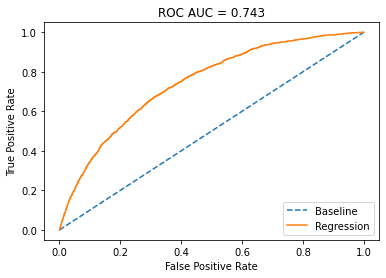

In [67]:
model_US_TL_LR = LogisticRegression(max_iter=1000)
class_model(model_US_TL_LR, 'US_TL_LR')

Некоторые мертики немного улучшились, но модель, по-прежнему, не видит миноритарный класс.

#### Простое отсечение данных в мажоританом классе

Попробуем сбалансировать данные удалением строк из мажоритарного класса.

In [68]:
n = df_train['default'].value_counts()[1]
df_0 = df_train.loc[(df_train['default'] == 0)].iloc[:n, :]
df_1 = df_train.loc[(df_train['default'] == 1)]
df_us = pd.concat([df_0, df_1])

Количество данных в классах одинаковое:

In [69]:
df_us.default.value_counts()

0    9372
1    9372
Name: default, dtype: int64

In [70]:
df_us.shape

(18744, 43)

Разбиваем получившуюся выборку на train и validation и обучаем три модели классификаторов.

In [71]:
train, validation = train_test_split(df_us, test_size=0.2, random_state=42)
X_train = train.drop(['client_id', 'default', 'sample'], axis=1)
Y_train = train['default']
X_validation = validation.drop(['client_id', 'default', 'sample'], axis=1)
y_true = validation['default']

#### LogisticRegression

,LR,DTC,RFC,OS_LR,OS_DTC,OS_RFC,US_TL_LR,US_LR
TN,12873.0000,11212.0000,12880.0000,12851.0000,11042.0000,12714.0000,12848.0000,1271.0000
FP,60.0000,1721.0000,53.0000,82.0000,1891.0000,219.0000,85.0000,616.0000
FN,1785.0000,1391.0000,1785.0000,1763.0000,1382.0000,1698.0000,1766.0000,582.0000
TP,42.0000,436.0000,42.0000,64.0000,445.0000,129.0000,61.0000,1280.0000
accuracy,0.8750,0.7892,0.8755,0.8750,0.7783,0.8701,0.8746,0.6804
precision,0.4118,0.2021,0.4421,0.4384,0.1905,0.3707,0.4178,0.6751
recall,0.0230,0.2386,0.0230,0.0350,0.2436,0.0706,0.0334,0.6874
f1,0.0435,0.2189,0.0437,0.0649,0.2138,0.1186,0.0618,0.6812
roc_auc,0.7432,0.5528,0.7137,0.7380,0.5487,0.7048,0.7433,0.7420


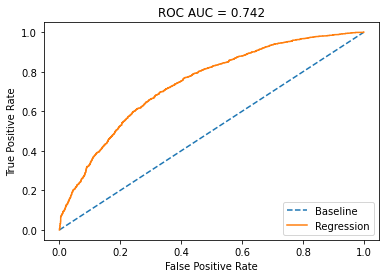

In [72]:
model_US_LR = LogisticRegression(max_iter=1000)
class_model(model_US_LR, 'US_LR')

In [73]:
validation.default.value_counts()

0    1887
1    1862
Name: default, dtype: int64

#### DecisionTreeClassifier

,LR,DTC,RFC,OS_LR,OS_DTC,OS_RFC,US_TL_LR,US_LR,US_DTC
TN,12873.0000,11212.0000,12880.0000,12851.0000,11042.0000,12714.0000,12848.0000,1271.0000,1085.0000
FP,60.0000,1721.0000,53.0000,82.0000,1891.0000,219.0000,85.0000,616.0000,802.0000
FN,1785.0000,1391.0000,1785.0000,1763.0000,1382.0000,1698.0000,1766.0000,582.0000,791.0000
TP,42.0000,436.0000,42.0000,64.0000,445.0000,129.0000,61.0000,1280.0000,1071.0000
accuracy,0.8750,0.7892,0.8755,0.8750,0.7783,0.8701,0.8746,0.6804,0.5751
precision,0.4118,0.2021,0.4421,0.4384,0.1905,0.3707,0.4178,0.6751,0.5718
recall,0.0230,0.2386,0.0230,0.0350,0.2436,0.0706,0.0334,0.6874,0.5752
f1,0.0435,0.2189,0.0437,0.0649,0.2138,0.1186,0.0618,0.6812,0.5735
roc_auc,0.7432,0.5528,0.7137,0.7380,0.5487,0.7048,0.7433,0.7420,0.5751


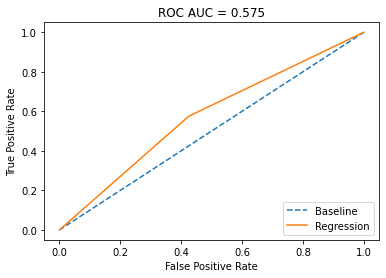

In [74]:
model_US_DTC = DecisionTreeClassifier(random_state=23)
class_model(model_US_DTC, 'US_DTC')

#### RandomForestClassifier

,LR,DTC,RFC,OS_LR,OS_DTC,OS_RFC,US_TL_LR,US_LR,US_DTC,US_RFC
TN,12873.0000,11212.0000,12880.0000,12851.0000,11042.0000,12714.0000,12848.0000,1271.0000,1085.0000,1218.0000
FP,60.0000,1721.0000,53.0000,82.0000,1891.0000,219.0000,85.0000,616.0000,802.0000,669.0000
FN,1785.0000,1391.0000,1785.0000,1763.0000,1382.0000,1698.0000,1766.0000,582.0000,791.0000,617.0000
TP,42.0000,436.0000,42.0000,64.0000,445.0000,129.0000,61.0000,1280.0000,1071.0000,1245.0000
accuracy,0.8750,0.7892,0.8755,0.8750,0.7783,0.8701,0.8746,0.6804,0.5751,0.6570
precision,0.4118,0.2021,0.4421,0.4384,0.1905,0.3707,0.4178,0.6751,0.5718,0.6505
recall,0.0230,0.2386,0.0230,0.0350,0.2436,0.0706,0.0334,0.6874,0.5752,0.6686
f1,0.0435,0.2189,0.0437,0.0649,0.2138,0.1186,0.0618,0.6812,0.5735,0.6594
roc_auc,0.7432,0.5528,0.7137,0.7380,0.5487,0.7048,0.7433,0.7420,0.5751,0.7246


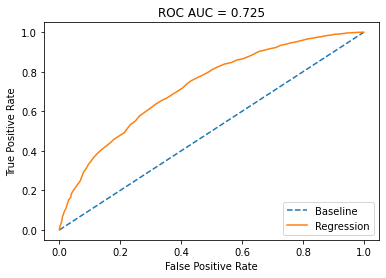

In [75]:
model_US_RFC = RandomForestClassifier()
class_model(model_US_RFC, 'US_RFC')

Модели научились различать классы и лучше всех это делает логистическая регрессия.

### Стандартизация

Хотя размах числовых переменных относительно невелик, попробуем их нормализовать с помощью StandardScaler.

In [76]:
df_us_std = df_us.copy()

In [77]:
df_us_std[num_cols].describe()

,age,score_bki,bki_request_cnt,income,app_date
count,18744.0000,18744.0000,18744.0000,18744.0000,18744.0000
mean,38.8988,-1.8097,2.1918,10.3059,59.5233
std,11.5346,0.5098,2.4763,0.6836,31.8707
min,21.0000,-3.5826,0.0000,8.0064,0.0000
25%,29.0000,-2.1699,1.0000,9.9035,32.0000
50%,37.0000,-1.8156,2.0000,10.3090,60.0000
75%,47.0000,-1.4663,3.0000,10.7144,86.0000
max,72.0000,0.1998,46.0000,13.8155,119.0000


In [78]:
scaler = StandardScaler()
df_us_std[num_cols] = scaler.fit_transform(df_us_std[num_cols].values)

Аналогичным образом стандартизуем числовые переменные в тестовой выборке.

In [79]:
df_test[num_cols] = scaler.transform(df_test[num_cols].values)

Проверяем результаты:

In [80]:
df_us_std[num_cols].describe()

,age,score_bki,bki_request_cnt,income,app_date
count,1.8744e+04,1.8744e+04,1.8744e+04,1.8744e+04,1.8744e+04
mean,4.3114e-16,-3.2339e-16,3.5915e-15,2.7044e-15,-7.6171e-18
std,1.0000e+00,1.0000e+00,1.0000e+00,1.0000e+00,1.0000e+00
min,-1.5518e+00,-3.4775e+00,-8.8514e-01,-3.3639e+00,-1.8677e+00
25%,-8.5821e-01,-7.0652e-01,-4.8131e-01,-5.8865e-01,-8.6361e-01
50%,-1.6463e-01,-1.1470e-02,-7.7475e-02,4.4810e-03,1.4959e-02
75%,7.0235e-01,6.7357e-01,3.2636e-01,5.9762e-01,8.3078e-01
max,2.8698e+00,3.9416e+00,1.7691e+01,5.1341e+00,1.8662e+00


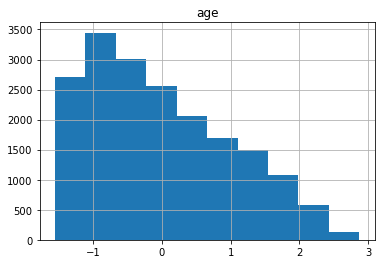

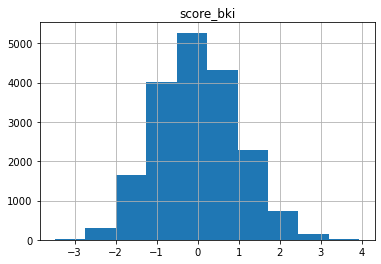

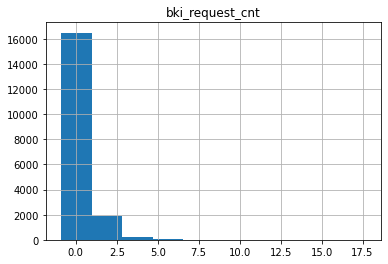

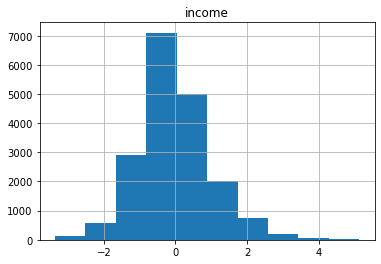

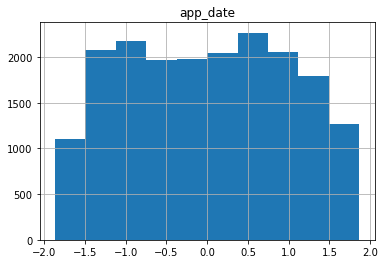

In [81]:
for col in num_cols:
    df_us_std[col].hist()
    plt.title(col)
    plt.show()

Разобьем полученную выборку на train и validation.

In [82]:
train, validation = train_test_split(df_us_std, test_size=0.2, random_state=42)
X_train = train.drop(['client_id', 'default', 'sample'], axis=1)
Y_train = train['default']
X_validation = validation.drop(['client_id', 'default', 'sample'], axis=1)
y_true = validation['default']

Обучим модель, давшую лучшие результаты:

,LR,DTC,RFC,OS_LR,OS_DTC,OS_RFC,US_TL_LR,US_LR,US_DTC,US_RFC,US_LR_norm
TN,12873.0000,11212.0000,12880.0000,12851.0000,11042.0000,12714.0000,12848.0000,1271.0000,1085.0000,1218.0000,1271.0000
FP,60.0000,1721.0000,53.0000,82.0000,1891.0000,219.0000,85.0000,616.0000,802.0000,669.0000,616.0000
FN,1785.0000,1391.0000,1785.0000,1763.0000,1382.0000,1698.0000,1766.0000,582.0000,791.0000,617.0000,582.0000
TP,42.0000,436.0000,42.0000,64.0000,445.0000,129.0000,61.0000,1280.0000,1071.0000,1245.0000,1280.0000
accuracy,0.8750,0.7892,0.8755,0.8750,0.7783,0.8701,0.8746,0.6804,0.5751,0.6570,0.6804
precision,0.4118,0.2021,0.4421,0.4384,0.1905,0.3707,0.4178,0.6751,0.5718,0.6505,0.6751
recall,0.0230,0.2386,0.0230,0.0350,0.2436,0.0706,0.0334,0.6874,0.5752,0.6686,0.6874
f1,0.0435,0.2189,0.0437,0.0649,0.2138,0.1186,0.0618,0.6812,0.5735,0.6594,0.6812
roc_auc,0.7432,0.5528,0.7137,0.7380,0.5487,0.7048,0.7433,0.7420,0.5751,0.7246,0.7421


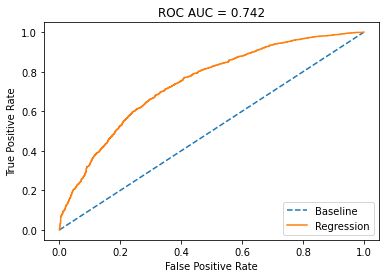

In [83]:
model_US_LR_norm = LogisticRegression(max_iter=1000)
class_model(model_US_LR_norm, 'US_LR_norm')

Результаты получились на одну десятитысячную лучше в метрике ROC AUC. Остальные метрики идетнтичны модели US_LR. Тем не менее, будем использовать эту модель в качестве базовой, т.к. она даст лучшие результаты после регуляризации.

## Регуляризация

Определим оптимальные гиперпараметры для нашей лучшей модели.

In [84]:
train, validation = train_test_split(df_us_std, test_size=0.2, random_state=42)
X_train = train.drop(['client_id', 'default', 'sample'], axis=1)
Y_train = train['default']
X_validation = validation.drop(['client_id', 'default', 'sample'], axis=1)
y_true = validation['default']

In [85]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и 
# с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression()

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

# model - модель логистической регрессии
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, Y_train)
model = gridsearch.best_estimator_

# печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 1.0
	class_weight: 'none'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: None
	solver: 'lbfgs'
	tol: 0.001
	verbose: 0
	warm_start: False


Подставляем полученные параметры:

,LR,DTC,RFC,OS_LR,OS_DTC,OS_RFC,US_TL_LR,US_LR,US_DTC,US_RFC,US_LR_norm,US_LR_norm_reg
TN,12873.0000,11212.0000,12880.0000,12851.0000,11042.0000,12714.0000,12848.0000,1271.0000,1085.0000,1218.0000,1271.0000,1272.0000
FP,60.0000,1721.0000,53.0000,82.0000,1891.0000,219.0000,85.0000,616.0000,802.0000,669.0000,616.0000,615.0000
FN,1785.0000,1391.0000,1785.0000,1763.0000,1382.0000,1698.0000,1766.0000,582.0000,791.0000,617.0000,582.0000,580.0000
TP,42.0000,436.0000,42.0000,64.0000,445.0000,129.0000,61.0000,1280.0000,1071.0000,1245.0000,1280.0000,1282.0000
accuracy,0.8750,0.7892,0.8755,0.8750,0.7783,0.8701,0.8746,0.6804,0.5751,0.6570,0.6804,0.6812
precision,0.4118,0.2021,0.4421,0.4384,0.1905,0.3707,0.4178,0.6751,0.5718,0.6505,0.6751,0.6758
recall,0.0230,0.2386,0.0230,0.0350,0.2436,0.0706,0.0334,0.6874,0.5752,0.6686,0.6874,0.6885
f1,0.0435,0.2189,0.0437,0.0649,0.2138,0.1186,0.0618,0.6812,0.5735,0.6594,0.6812,0.6821
roc_auc,0.7432,0.5528,0.7137,0.7380,0.5487,0.7048,0.7433,0.7420,0.5751,0.7246,0.7421,0.7422


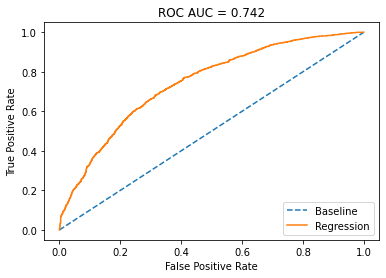

In [86]:
model_US_LR_norm_reg = LogisticRegression(
    penalty='none', max_iter=1000, solver='lbfgs', tol=0.001)
class_model(model_US_LR_norm_reg, 'US_LR_norm_reg')

Результаты классификации немного улучшились, стало на несколько штук меньше ложных результатов.

## Обучение модели на данных, очищенных от выбросов

Проведем все те же преобразования, что и для полного датасета.

In [87]:
df_train_irq.decline_app_cnt = df_train_irq.decline_app_cnt.apply(
    lambda x: x if x < 3 else 3)
lble_encod(df_train_irq, cat_cols)
df_train_irq = pd.get_dummies(df_train_irq, columns=cat_cols)
lble_encod(df_train_irq, bin_cols)

In [88]:
df_train_irq.shape

(69827, 43)

Разобьем датасет на обучающую и валидационную выборки.

In [89]:
train, validation = train_test_split(
    df_train_irq, test_size=0.2, random_state=42)
X_train_irq = train.drop(['client_id', 'default', 'sample'], axis=1).values
Y_train_irq = train['default'].values
X_validation_irq = validation.drop(
    ['client_id', 'default', 'sample'], axis=1).values
y_true_irq = validation['default'].values

Посмотрим на результаты на примере логистической регресси.

,LR_irq,LR
TN,12201.0000,12873.0000
FP,40.0000,60.0000
FN,1685.0000,1785.0000
TP,40.0000,42.0000
accuracy,0.8765,0.8750
precision,0.5000,0.4118
recall,0.0232,0.0230
f1,0.0443,0.0435
roc_auc,0.7414,0.7432


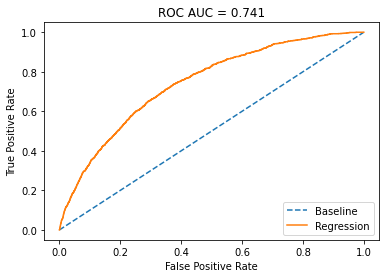

In [90]:
model_LR_irq = LogisticRegression(max_iter=1000)
model_LR_irq.fit(X_train_irq, Y_train_irq)
y_pred = model_LR_irq.predict(X_validation_irq)
y_pred_proba = model_LR_irq.predict_proba(X_validation_irq)[:, 1]
metric = cnt_metr(y_true_irq, y_pred, y_pred_proba)
df_metrics_irq = pd.DataFrame.from_dict(
    metric, orient='index', columns=['LR_irq'])
display(df_metrics_irq.join(df_metrics['LR']))
roc_auc_plt(y_true_irq, y_pred_proba)

Метрики похожи на те, что были получены ранее на датасете, не очищенном от выбросов.

Возьмем модель, покзавшую ранее лучшие результаты - логистическую регрессию с undersampling, стандартизацией и регуляризацией.

In [91]:
n = df_train_irq['default'].value_counts()[1]
df_0_irq = df_train_irq.loc[(df_train_irq['default'] == 0)].iloc[:n, :]
df_1_irq = df_train_irq.loc[(df_train_irq['default'] == 1)]
df_us_irq = pd.concat([df_0_irq, df_1_irq])

In [92]:
df_us_irq_std = df_us_irq.copy()
df_us_irq_std[num_cols] = scaler.transform(df_us_irq_std[num_cols].values)

In [93]:
train, validation = train_test_split(df_us_irq_std, test_size=0.2, random_state=42)
X_train_irq = train.drop(['client_id', 'default', 'sample'], axis=1)
Y_train_irq = train['default']
X_validation_irq = validation.drop(['client_id', 'default', 'sample'], axis=1)
y_true_irq = validation['default']

,LR_irq,US_LR_irq_norm_reg,US_LR_norm_reg
TN,12201.0000,1153.0000,1272.0000
FP,40.0000,574.0000,615.0000
FN,1685.0000,572.0000,580.0000
TP,40.0000,1187.0000,1282.0000
accuracy,0.8765,0.6713,0.6812
precision,0.5000,0.6740,0.6758
recall,0.0232,0.6748,0.6885
f1,0.0443,0.6744,0.6821
roc_auc,0.7414,0.7309,0.7422


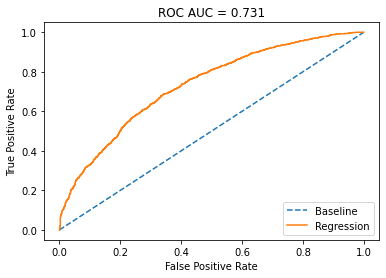

In [94]:
model_US_LR_norm_reg.fit(X_train_irq, Y_train_irq)
y_pred = model_US_LR_norm_reg.predict(X_validation_irq)
y_pred_proba = model_US_LR_norm_reg.predict_proba(X_validation_irq)[:, 1]
metric = cnt_metr(y_true_irq, y_pred, y_pred_proba)
df_metrics_irq['US_LR_irq_norm_reg'] = pd.Series(metric)
display(df_metrics_irq.join(df_metrics['US_LR_norm_reg']))
roc_auc_plt(y_true_irq, y_pred_proba)

Результаты ухудшились. Не будем использовать эту дополнительную обработку.

## Submission

Применим модель, давшую лучшие результаты, к тестовой выборке.

In [95]:
pd.set_option('precision', 6)
X_test = df_test.drop(['client_id', 'default', 'sample'], axis=1)
y_pred_proba = model_US_LR_norm_reg.predict_proba(X_test)[:, 1]
df_test['default'] = y_pred_proba
submission = df_test[['client_id', 'default']]
submission.to_csv('submission.csv', index=False)

In [96]:
submission.sample(5)

,client_id,default
4135,109369,0.674963
15244,31592,0.740754
4981,39086,0.619533
18667,52738,0.231637
135,45431,0.161040


В результате предсказания, количество недефолтных клиентов превышает дефолтных в 2 раза. Тогда как, в обучающей выборке, где содержались реальные данные, соотношение было равно 7. 

Это косвенно указывает на то, что модель далека от совершенства. Данное соотношение должно сохраняться.

In [97]:
ratio_1 = ((df_test.default < 0.5).value_counts() / (df_test.default >= 0.5).value_counts())[1]
round(ratio_1)

2

In [98]:
round(ratio)

7